In [1]:
from activation_visualization import dataset_average, effective_receptive_field, backprop_maximization, activation_triggered_average, normalizeZeroOne, get_input_output_shape
from models.model_builder import load_model
from torchvision import transforms
from torch.utils.data import DataLoader
from torchvision import datasets
import torch
from matplotlib import pyplot as plt
from tqdm import tqdm
from torchinfo import summary
import numpy as np
import retinal_rl_wrapper as retinal_stats

In [14]:
model = load_model("../models/lindseydefault")
summary(model)

Layer (type:depth-idx)                   Param #
LindseyNet                               --
├─Sequential: 1-1                        --
│    └─Conv2d: 2-1                       7,808
│    └─ReLU: 2-2                         --
│    └─Conv2d: 2-3                       2,593
│    └─ReLU: 2-4                         --
├─Sequential: 1-2                        --
│    └─Conv2d: 2-5                       2,624
│    └─ReLU: 2-6                         --
│    └─Conv2d: 2-7                       82,976
│    └─ReLU: 2-8                         --
├─Sequential: 1-3                        --
│    └─Flatten: 2-9                      --
│    └─Linear: 2-10                      33,555,456
│    └─ReLU: 2-11                        --
│    └─Linear: 2-12                      10,250
├─Softmax: 1-4                           --
Total params: 33,661,707
Trainable params: 33,661,707
Non-trainable params: 0

In [15]:
model = model.get_sequential()
transf = [transforms.ToTensor()]
if model[0].in_channels==1:
    transf.append(transforms.Grayscale())
train_data = datasets.CIFAR10(root="../data", train=True, download=True, transform=transforms.Compose(transf))
train_loader = DataLoader(train_data, batch_size=256, shuffle=False)
summary(model, (1,model[0].in_channels,32,32))

Files already downloaded and verified


Layer (type:depth-idx)                   Output Shape              Param #
Sequential                               [1, 10]                   --
├─Conv2d: 1-1                            [1, 32, 32, 32]           7,808
├─ReLU: 1-2                              [1, 32, 32, 32]           --
├─Conv2d: 1-3                            [1, 1, 32, 32]            2,593
├─ReLU: 1-4                              [1, 1, 32, 32]            --
├─Conv2d: 1-5                            [1, 32, 32, 32]           2,624
├─ReLU: 1-6                              [1, 32, 32, 32]           --
├─Conv2d: 1-7                            [1, 32, 32, 32]           82,976
├─ReLU: 1-8                              [1, 32, 32, 32]           --
├─Flatten: 1-9                           [1, 32768]                --
├─Linear: 1-10                           [1, 1024]                 33,555,456
├─ReLU: 1-11                             [1, 1024]                 --
├─Linear: 1-12                           [1, 10]                

## Intermediate Representation

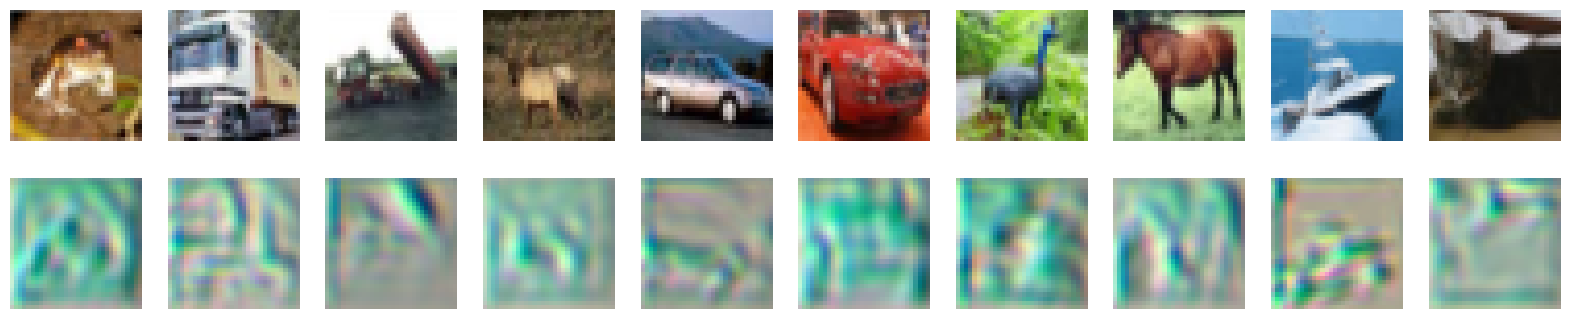

In [16]:
imgs = next(iter(train_loader))
processed = model[:5](imgs[0]).detach()

fig, axes = plt.subplots(2, 10, figsize=(20,4))
for ax, im in zip(axes[0], imgs[0]):
    ax.imshow(im.movedim(0,2), cmap='gray')
    ax.axis('off')
for ax, im in zip(axes[1], processed):
    ax.imshow(normalizeZeroOne(im[:min(3, im.shape[0])].movedim(0,2)), cmap='gray')
    ax.axis('off')

## Receptive Fields

100%|██████████| 32/32 [00:00<00:00, 564.67it/s]


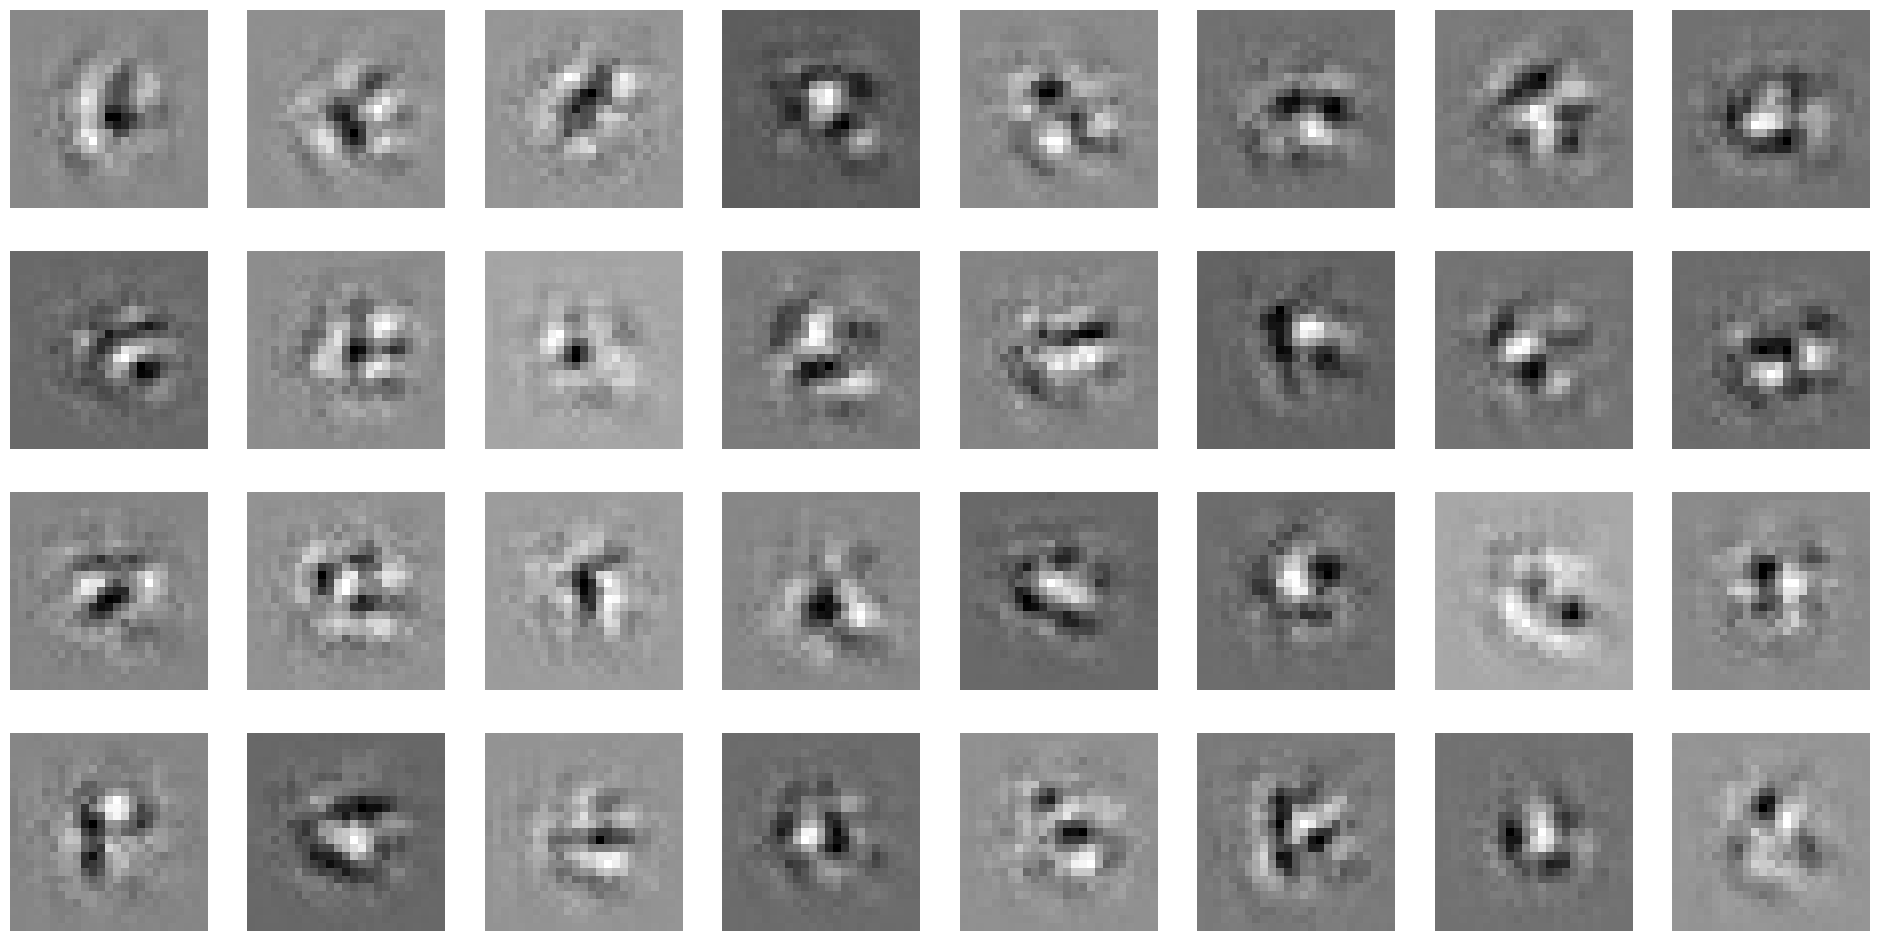

In [17]:
temp_model = model[:5]
eff_rfs = effective_receptive_field(temp_model, n_batch=1)
if len(eff_rfs)==1:
    plt.imshow(torch.mean(eff_rfs[0], dim=0), cmap="gray")
    plt.axis('off')
else:
    fig, axes = plt.subplots(4, 8, figsize=(24,12))
    for eff_rf, ax in zip(eff_rfs, axes.flat):
        ax.imshow(torch.mean(eff_rf, dim=0), cmap="gray")
        ax.axis('off')

In [24]:
eff_rfs = activation_triggered_average(temp_model, n_iter=16)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, i in train_data.class_to_idx.items():
    ax = axes.flat[i]
    ax.imshow(normalizeZeroOne(eff_rfs[i].movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)

 88%|████████▊ | 14/16 [00:17<00:02,  1.41s/it]

In [ ]:
back_maxs = backprop_maximization(model[:-1], n_iter=512, batch_size=1, reduction=True, smoothened=True)

fig, axes = plt.subplots(2, 5, figsize=(20,8))
for class_name, back_max, ax in zip(train_data.classes, back_maxs, axes.flat):
    out = model(back_max.repeat(1,1,1,1))
    index = out.argmax()
    prob = out.max()

    ax.imshow(back_max.movedim(0,2))
    ax.axis('off')
    ax.set_title(class_name + " - {0:.0%}".format(prob))

  0%|          | 0/10 [00:07<?, ?it/s]


KeyboardInterrupt: 

100%|██████████| 10/10 [00:19<00:00,  1.94s/it]


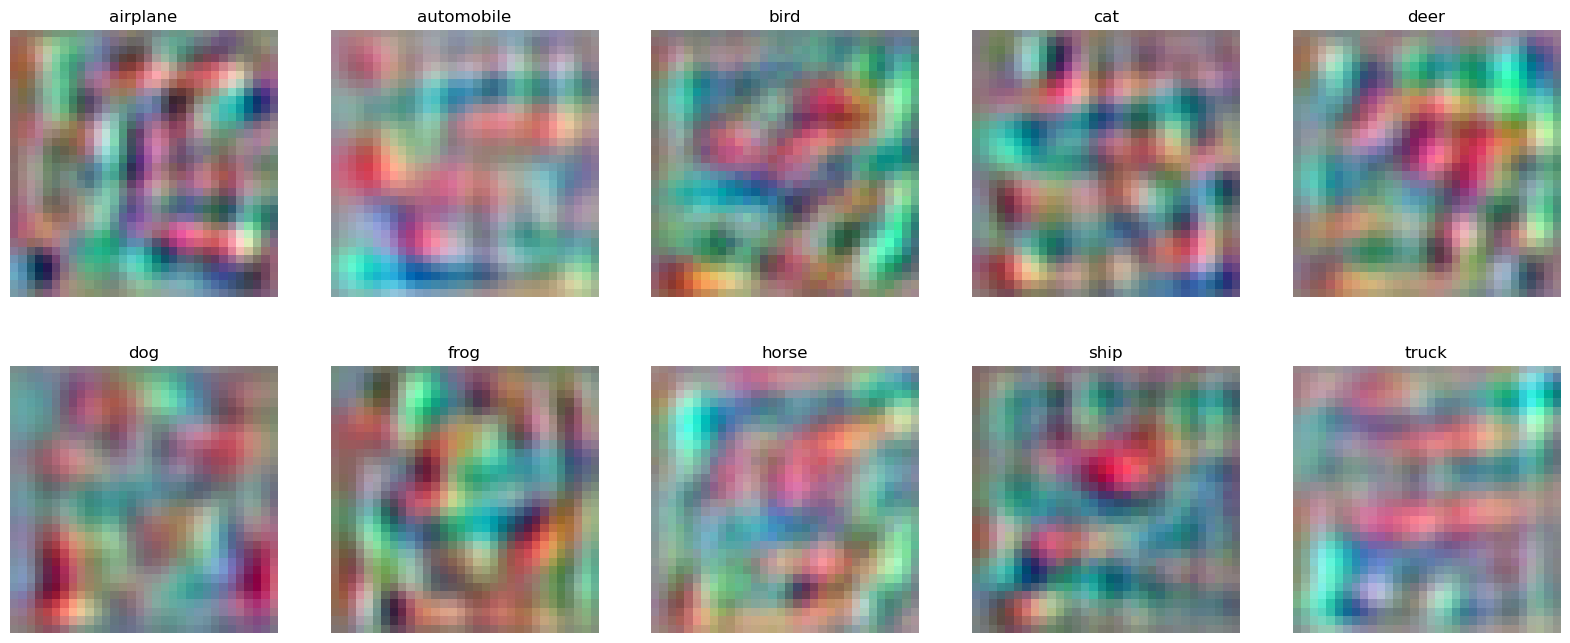

In [19]:
eff_rfs = effective_receptive_field(model, n_batch=512)
fig, axes = plt.subplots(2, 5, figsize=(20,8))

for class_name, eff_rf, ax  in zip(train_data.classes, eff_rfs, axes.flat):
    ax.imshow(normalizeZeroOne(eff_rf.movedim(0,2)))
    ax.axis('off')
    ax.set_title(class_name)